In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from os import listdir
train_data_li = listdir('./train/')
train_data_li

import sys
mod = sys.modules[__name__]
for name in train_data_li:
    setattr(mod, name.split('.')[0], pd.read_csv('./train/' + name))
    
train_activity.shape, train_combat.shape, train_pledge.shape, train_trade.shape, train_payment.shape, train_label.shape

((1601834, 17),
 (1574671, 13),
 (1083384, 15),
 (1849325, 11),
 (66432, 3),
 (40000, 3))

# 다 합쳐서 new baseline 구축

((40000, 425), (40000,))

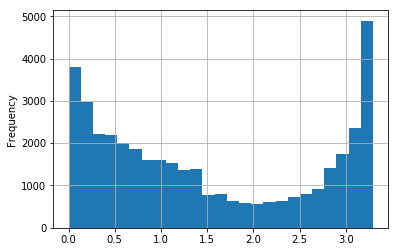

In [3]:
df = train_activity[
        [col for col in train_activity.columns if col not in ['server',  'char_id']]
    ].groupby(['day', 'acc_id']).sum().reset_index()

df_grouped = df.groupby('day')
p = df_grouped.get_group(1)
for i in range(2, 29):
    p = pd.merge(p, df_grouped.get_group(i), on='acc_id', how='outer',
                 suffixes=('_'+str(i-1), '_'+str(i)))
p = p[[col for col in p.columns if ('day' not in col) & ('char' not in col)]]
p = p.fillna(0).set_index('acc_id')

playtime_daily = train_activity.groupby(['acc_id', 'day'])['playtime'].sum().unstack().fillna(0)
exp_weights = np.sqrt(np.arange(1, 29)) / np.sqrt(np.arange(1, 29)).sum()
playtime_exp = playtime_daily * exp_weights
playtime_exp.sum(axis=1).plot.hist(bins=25, grid=True)

df = p.reset_index()
p2 = pd.DataFrame(playtime_exp.sum(axis=1), columns=['exp_playtime']).reset_index()
df = pd.merge(df, p2, on='acc_id')

d = pd.DataFrame(list(set([(i, j) for i,j in train_activity[['day', 'acc_id']].values])), columns=['day', 'acc_id'])
df = pd.merge(df, d.groupby('acc_id').count().reset_index(), on='acc_id')

train_act_time = train_activity[['acc_id', 'day', 'playtime', 'fishing', 'private_shop']]
train_act_time = train_act_time.groupby(['acc_id', 'day']).sum()
train_act_time['resttime'] = train_act_time['fishing'] + train_act_time['private_shop']
train_act_time['tr_play'] = (train_act_time['playtime'] - train_act_time['resttime']) / train_act_time['playtime']
train_act_time['tr_rest'] = train_act_time['resttime'] / train_act_time['playtime']
rest = train_act_time['tr_rest'].unstack().fillna(1)
play = train_act_time['tr_play'].unstack().fillna(0)

rest.columns = ['rest_'+str(i) for i in range(1, 29)]
play.columns = ['play_'+str(i) for i in range(1, 29)]

exp_weights = np.sqrt(np.arange(1, 29)) / np.sqrt(np.arange(1, 29)).sum()
rest['exp_rest'] = (rest * exp_weights).sum(axis=1)
play['exp_play'] = (play * exp_weights).sum(axis=1)

df = pd.merge(df, rest.reset_index(), on='acc_id')
df = pd.merge(df, play.reset_index(), on='acc_id')

label = np.where(train_label.set_index('acc_id').loc[p.index]['survival_time'].values == 64, 1, 0)

df.shape, label.shape

# expected return

In [7]:
sort_acc_id = p.index

In [12]:
is_churn_label = np.where(train_label.set_index('acc_id').loc[sort_acc_id]['survival_time'].values == 64, 1, 0)
amount_label = train_label.set_index('acc_id').loc[sort_acc_id]['amount_spent']
survtime_label = train_label.set_index('acc_id').loc[sort_acc_id]['survival_time']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1:]], label, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((21000, 424), (7000, 424), (12000, 424), (21000,), (7000,), (12000,))

In [27]:
print(np.all(is_churn_label[X_train.index] == y_train))
print(np.all(is_churn_label[X_valid.index] == y_valid))
print(np.all(is_churn_label[X_test.index] == y_test))

True
True
True


In [69]:
y_train1 = is_churn_label[X_train.index]
y_train1a = survtime_label.values[X_train.index]
y_train2 = amount_label.values[X_train.index]

y_valid1 = is_churn_label[X_valid.index]
y_valid1a = survtime_label.values[X_valid.index]
y_valid2 = amount_label.values[X_valid.index]

y_test1 = is_churn_label[X_test.index]
y_test1a = survtime_label.values[X_test.index]
y_test2 = amount_label.values[X_test.index]

In [40]:
import xgboost as xgb

params =   {
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'auc',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 200,
    'max_leaves': 300
}

In [41]:
VALID = True
if VALID == True:

    tr_data1 = xgb.DMatrix(X_train, y_train)
    va_data1 = xgb.DMatrix(X_valid, y_valid)

    watchlist = [(tr_data1, 'train'), (va_data1, 'valid')]

    %time model1 = xgb.train(params, tr_data1, 500, watchlist, maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

[0]	train-auc:0.966033	valid-auc:0.743517
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 30 rounds.
[50]	train-auc:0.999891	valid-auc:0.835683
[100]	train-auc:0.999917	valid-auc:0.840125
[150]	train-auc:0.999912	valid-auc:0.841082
[200]	train-auc:0.999911	valid-auc:0.841591
[250]	train-auc:0.999911	valid-auc:0.841908
[300]	train-auc:0.999911	valid-auc:0.842114
[350]	train-auc:0.999912	valid-auc:0.842263
[400]	train-auc:0.999912	valid-auc:0.842311
[450]	train-auc:0.999912	valid-auc:0.842332
[499]	train-auc:0.999913	valid-auc:0.842369


In [47]:
model1.save_model('0004-1.model')

In [49]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = np.where(model1.predict(xgb.DMatrix(X_test)) > 0.5, 1, 0)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

(0.7646666666666667, 0.7890017931858936)

## Model B - Amount Spent

In [98]:
params2 =   {
    'objective' : 'reg:linear',
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'rmse',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 200,
    'max_leaves': 300
}

In [99]:
VALID = True
if VALID == True:

    tr_data2 = xgb.DMatrix(X_train, y_train2)
    va_data2 = xgb.DMatrix(X_valid, y_valid2)

    watchlist = [(tr_data2, 'train'), (va_data2, 'valid')]

    %time model1a = xgb.train(params2, tr_data2, 500, watchlist, maximize=False, early_stopping_rounds = 30, verbose_eval=50)

[0]	train-rmse:0.816628	valid-rmse:0.804051
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:0.579939	valid-rmse:0.724347
[100]	train-rmse:0.45623	valid-rmse:0.72948
Stopping. Best iteration:
[71]	train-rmse:0.520659	valid-rmse:0.7225

Wall time: 1min 57s


In [100]:
y_pred = model1a.predict(xgb.DMatrix(X_test))
y_pred

array([0.16520593, 0.1349616 , 0.16198963, ..., 1.5253782 , 0.19498032,
       0.1470868 ], dtype=float32)

In [108]:
np.sqrt(np.mean((y_test2 - y_pred) ** 2))

0.7218267636226796

In [111]:
np.mean(y_test2)

0.12734680129560605

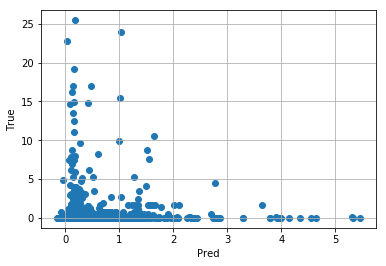

In [116]:
plt.scatter(y_pred, y_test2)
plt.xlabel('Pred')
plt.ylabel('True')
plt.grid(True); plt.show()

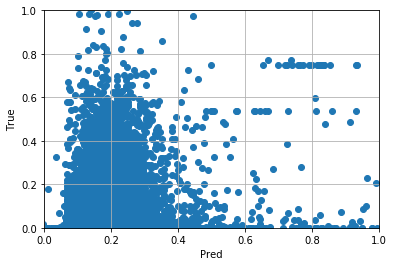

In [126]:
plt.scatter(y_pred, y_test2)
plt.xlabel('Pred')
plt.ylabel('True')
plt.axis([0, 1, 0, 1])
plt.grid(True); plt.show()

In [141]:
train_payment.acc_id.nunique()

23726

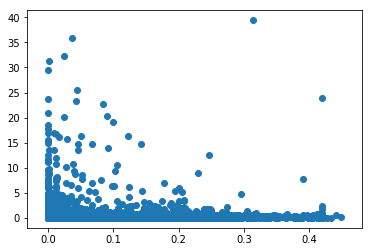

In [147]:
t = pd.concat((train_payment.groupby(['acc_id', 'day']).mean().unstack().fillna(0).mean(axis=1), train_label.set_index('acc_id')['amount_spent']), axis=1).fillna(0)
plt.scatter(t[0], t['amount_spent'])

# 어떤 유저가 이탈을 많이 할 것인가?
# 어떤 유저가 과금을 많이 할 것인가?

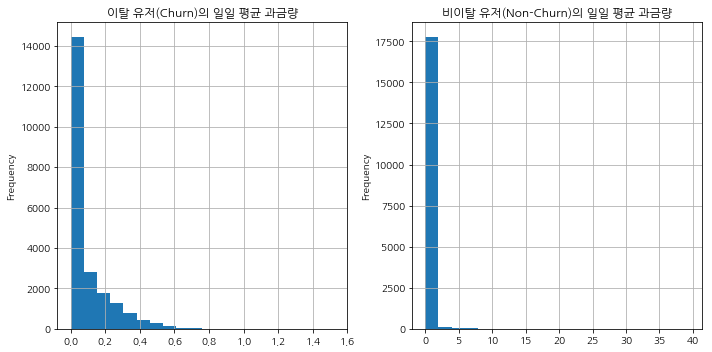

In [166]:
plt.rcParams["font.family"] = 'NanumGothic'

fig = plt.figure(figsize=(10, 5), facecolor='w')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
train_label[train_label['survival_time'] == 64]['amount_spent'].plot.hist(ax=ax1, grid=True, bins=20)
train_label[train_label['survival_time'] != 64]['amount_spent'].plot.hist(ax=ax2, grid=True, bins=20)
ax1.set_title('이탈 유저(Churn)의 일일 평균 과금량', fontsize=12)
ax2.set_title('비이탈 유저(Non-Churn)의 일일 평균 과금량', fontsize=12)
plt.tight_layout()

In [177]:
train_label[train_label['survival_time'] == 64]['acc_id'].nunique()

21996

In [178]:
train_payment['acc_id'].nunique()

23726

In [180]:
len(set(train_payment['acc_id']).intersection(set(train_label[train_label['survival_time'] == 64]['acc_id'])))

13260

In [181]:
len(set(train_payment['acc_id']).intersection(set(train_label[train_label['survival_time'] != 64]['acc_id'])))

10466